In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 27 10:40:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

## data set


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1tZlrPeJf7geYfRRTxeRhdPU_Hq5m8tg6


Downloading...
From: https://drive.google.com/uc?id=1tZlrPeJf7geYfRRTxeRhdPU_Hq5m8tg6
To: /content/Travel_TripAdvisor_v1.zip
100% 155k/155k [00:00<00:00, 97.1MB/s]


In [ ]:
!unzip "Travel_TripAdvisor_v1.zip"  -d  "/content"

Archive:  Travel_TripAdvisor_v1.zip
   creating: /content/Travel_TripAdvisor_v1/
  inflating: /content/Travel_TripAdvisor_v1/Data_TripAdvisor_v1.xls  
  inflating: /content/Travel_TripAdvisor_v1/ReadMe.html  


In [ ]:
!pip install pandas openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

xls = pd.ExcelFile(r"Travel_TripAdvisor_v1/Data_TripAdvisor_v1.xls") 

rating_df = xls.parse(0) #2 is the sheet number+1 thus if the file has only 1 sheet write 0 in paranthesis



In [ ]:
rating_df

,ID_USER,USER_STATE,USER_TIMEZONE,ID_HOTEL,HOTEL_CITY,HOTEL_STATE,HOTEL_TIMEZONE,Trip Type,Rating
0,45,GA,Eastern,105170,Memphis,TN,Central,3,5
1,45,GA,Eastern,223229,SanAntonio,TX,Central,3,5
2,45,GA,Eastern,258688,Albuquerque,NM,Mountain,3,5
3,45,GA,Eastern,98827,ELPaso,TX,Central,3,5
4,45,GA,Eastern,99518,SanAntonio,TX,Central,3,3
...,...,...,...,...,...,...,...,...,...
4664,65440,MI,Eastern,95715,Minneapolis,MN,Central,4,5
4665,65457,AZ,Mountain,1027019,FortWorth,TX,Central,3,3
4666,65457,AZ,Mountain,224458,Milwaukee,WI,Central,3,3
4667,65457,AZ,Mountain,223749,Columbus,OH,Eastern,3,2


In [ ]:

rating_df.rename(columns = {'ID_USER':'userID'}, inplace = True)
rating_df.rename(columns = {'ID_HOTEL':'itemID'}, inplace = True)


In [ ]:
rating_df.rename(columns = {'Rating':'rating'}, inplace = True)

In [ ]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)

In [ ]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [ ]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

### Analysis of column rating

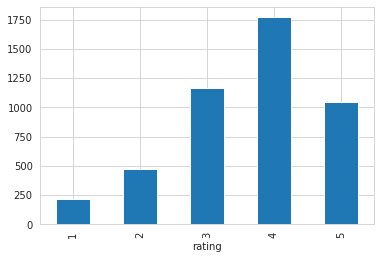

In [ ]:
rating_df.groupby(['rating']).size().plot(kind = "bar")

# Algorithm:




Hybrid recommendation

In [ ]:
!pip install lightfm
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=918039 sha256=a0d4f112ccbe6cd15e2ef409a84e652f4180a2f5258b89a004948fff4cbb95b0
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.0/339.0 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 63.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

In [ ]:
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k 
from lightfm.evaluation import recall_at_k 

In [ ]:
# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

In [ ]:
lightFM_df=rating_df

In [ ]:
lightFM_df.columns

In [ ]:
features =list( lightFM_df[[ 'HOTEL_TIMEZONE', 'HOTEL_STATE', 'HOTEL_CITY']])
#publishers =list( lightFM_df['publisher'])
features=iter(features)
#publishers=iter(publishers)

In [ ]:
user_features =list( lightFM_df[[ 'USER_STATE','USER_TIMEZONE','Trip Type']])
#publishers =list( lightFM_df['publisher'])
user_features=iter(user_features)
#publishers=iter(publishers)

In [ ]:
dataset = Dataset()

In [ ]:
dataset.fit(users=lightFM_df['userID'], 
            items=lightFM_df['itemID'],
             item_features=features,user_features=user_features)

# quick check to determine the number of unique users and items in the data
num_users, num_items = dataset.interactions_shape()
print(f'Num users: {num_users}, num_items: {num_items}.')

Num users: 1202, num_items: 1890.


In [ ]:
item_features = dataset.build_item_features((x, y) for x,y in zip(rating_df.itemID,features))
user_features = dataset.build_item_features((x, y) for x,y in zip(rating_df.userID,user_features))

In [ ]:
#  TOP K 
K = 20
# model learning rate
LR = 0.1
# no of latent factors
NO_COMPONENTS = 50
SEED=42
#epochs
EPOCHS=100
# no of threads to fit model
THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6


In [ ]:
lightFM_df

,userID,USER_STATE,USER_TIMEZONE,itemID,HOTEL_CITY,HOTEL_STATE,HOTEL_TIMEZONE,Trip Type,rating
0,45,GA,Eastern,105170,Memphis,TN,Central,3,5
1,45,GA,Eastern,223229,SanAntonio,TX,Central,3,5
2,45,GA,Eastern,258688,Albuquerque,NM,Mountain,3,5
3,45,GA,Eastern,98827,ELPaso,TX,Central,3,5
4,45,GA,Eastern,99518,SanAntonio,TX,Central,3,3
...,...,...,...,...,...,...,...,...,...
4664,65440,MI,Eastern,95715,Minneapolis,MN,Central,4,5
4665,65457,AZ,Mountain,1027019,FortWorth,TX,Central,3,3
4666,65457,AZ,Mountain,224458,Milwaukee,WI,Central,3,3
4667,65457,AZ,Mountain,223749,Columbus,OH,Eastern,3,2


In [ ]:
interactions, weights = dataset.build_interactions(lightFM_df[['userID','itemID','rating']].values)

train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=.2,
    random_state=np.random.RandomState(SEED))

In [ ]:
model = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LR, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

In [ ]:
model.fit(interactions=train_interactions,
           user_features=user_features,
           item_features=item_features,
           epochs=EPOCHS
           )

EVALUATE

In [ ]:
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

In [ ]:
TEST_PERCENTAGE=0.2
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, 
    interactions.col, 
    interactions.data, 
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()
cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

In [ ]:
from recommenders.utils.timer import Timer
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

Took 0.1 seconds for prepare and predict test data.


In [ ]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()


In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 0.1 seconds for prepare and predict test data.


In [ ]:
NO_THREADS=15
with Timer() as test_time:
    all_predictions = prepare_all_predictions(lightFM_df, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model, 
                                               user_features=user_features,
                                                item_features=item_features,
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 926.3 seconds for prepare and predict all data.


In [ ]:

from lightfm import cross_validation
# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k 
from lightfm.evaluation import recall_at_k 

In [ ]:

print("Train precision: %.5f" % precision_at_k(model, train_interactions, k=10, user_features=user_features,item_features=item_features).mean())
print("Test precision: %.5f" % precision_at_k(model, test_interactions, k=10,user_features=user_features,item_features=item_features).mean())

Train precision: 0.30742
Test precision: 0.00349


In [ ]:
print("Train recall: %.5f" % recall_at_k(model, train_interactions, k=20,user_features=user_features,item_features=item_features).mean())
print("Test recall: %.5f" % recall_at_k(model, test_interactions, k=20,user_features=user_features,item_features=item_features).mean())

Train recall: 1.00000
Test recall: 0.04241
